In [ ]:
# Autor: Luiz Felipe Barro Alves
# data: 20/04/2025

# $$\text{INFORMAÇÕES SOBRE O CÓDIGO:}$$
- ## Cada célula deste código descreve e executa cada uma das etapas necessárias para a implementação da atividade.

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.io import wavfile
from scipy.signal import remez, freqz

# Sinal de áudio

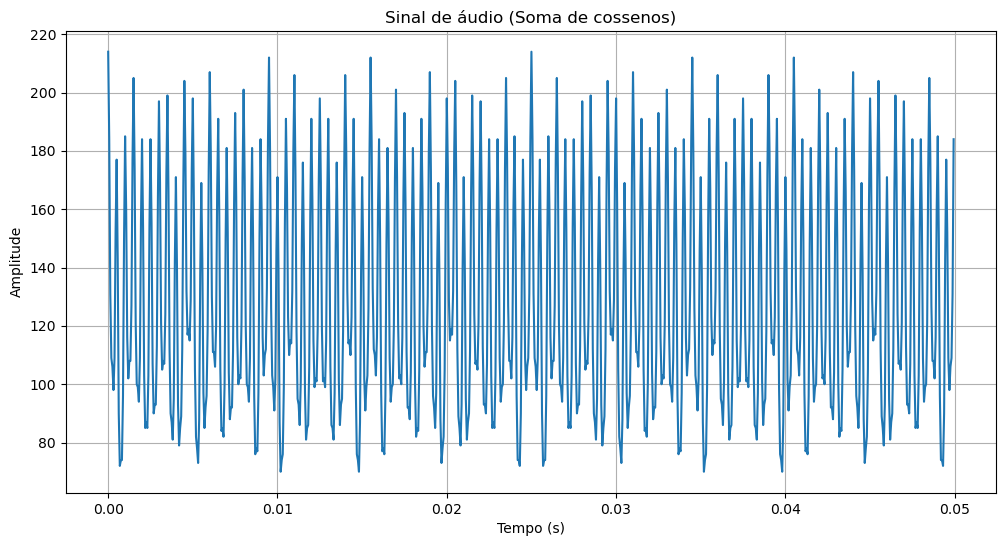

In [21]:
sample_rate, data = wavfile.read('sinal_1.wav')

time  = np.linspace(0.0, (1/sample_rate)*len(data), len(data))
visual_time = 0.05 # Tempo de visualização, pois há muitas amostras para plotar
n_samples = int(sample_rate * visual_time) # Quantidade de amostras a serem plotadas

plt.figure(figsize=(12, 6))
plt.plot(time[:n_samples], data[:n_samples])
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.title("Sinal de áudio (Soma de cossenos)")
plt.grid()
plt.show()

# Determinando as componentes de frequência via FFT da biblioteca numpy

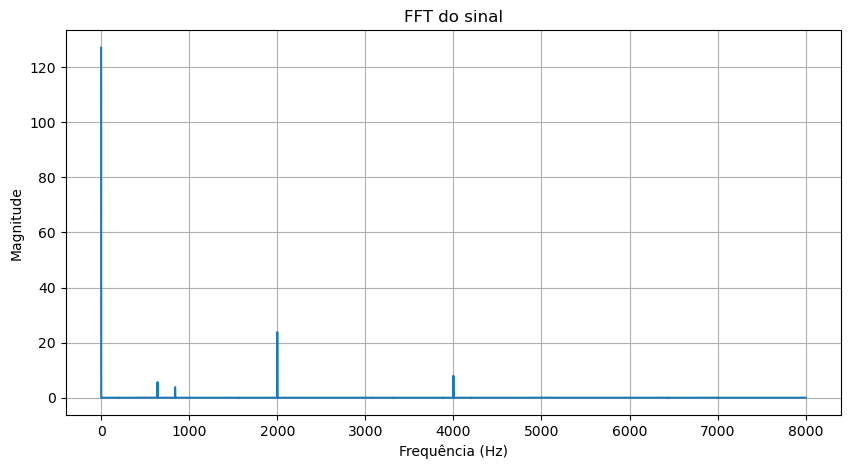

In [22]:
N = len(data)

# Calculando a FFT
fft_result = np.fft.fft(data)
fft_freqs = np.fft.fftfreq(N, d=1/sample_rate)

# Pegando apenas a parte positiva da FFT (por simetria)
half_N = N // 2
fft_freqs = fft_freqs[:half_N]
fft_magnitude = np.abs(fft_result[:half_N]) / N  
# Plot
plt.figure(figsize=(10, 5))
plt.plot(fft_freqs, fft_magnitude)
plt.title('FFT do sinal')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()


In [23]:
# Índices das 6 maiores amplitudes
top5_idx = np.argsort(fft_magnitude)[-6:]

# Frequências correspondentes
top5_freqs = fft_freqs[top5_idx]
top5_mags = fft_magnitude[top5_idx]

# Exibindo os resultados
for f, m in zip(top5_freqs, top5_mags):
    print(f'Frequência: {f:.2f} Hz, Magnitude: {m:.3f}')


Frequência: 839.99 Hz, Magnitude: 3.853
Frequência: 640.03 Hz, Magnitude: 4.428
Frequência: 639.98 Hz, Magnitude: 5.644
Frequência: 4000.00 Hz, Magnitude: 7.951
Frequência: 2000.00 Hz, Magnitude: 23.821
Frequência: 0.00 Hz, Magnitude: 127.029


# Determinando as componentes de frequência via DFT implementada na disciplina

In [24]:
N = 2**10 # Tamanho da DFT

k = np.array([np.arange(0, N)]) # Número de amostras
n = np.arange(0, N) # Índice do somatório
k_T = k.reshape(-1, 1) # Número de amostras organizadas como uma matriz Nx1

In [25]:
func = data[:N]
func_T = func.reshape(-1, 1) # Amostras organizadas como uma matriz Nx1

Wn = np.exp(-2j*np.pi/N) # Definição de Wn

M_result = Wn**(k_T*n) # Matriz com as exponenciais complexas

DFT = M_result @ func_T

<>:9: SyntaxWarning: invalid escape sequence '\O'
<>:9: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_21505/3260303011.py:9: SyntaxWarning: invalid escape sequence '\O'
  axs.set_xlabel('$|\Omega[k]$')


[Text(0.0, 0, '0'),
 Text(0.7853981633974483, 0, '$\\pi/4$'),
 Text(1.5707963267948966, 0, '$\\pi/2$'),
 Text(2.356194490192345, 0, '$3\\pi/4$'),
 Text(3.141592653589793, 0, '$\\pi$')]

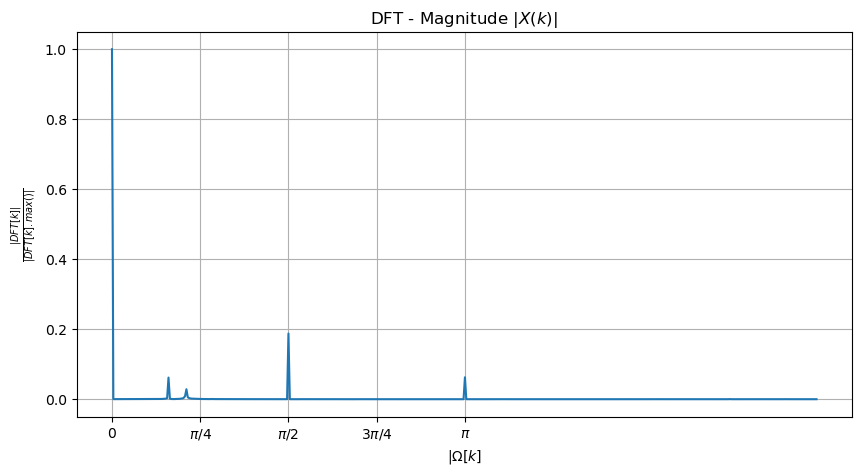

In [26]:
xticks = [0, np.pi/4, np.pi/2, (3*np.pi)/4, np.pi]
xticklabels = ['0', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$']
# Pegando apenas a parte positiva da FFT (por simetria)
half_N = N // 2

fig, axs  = plt.subplots(1, 1, figsize=(10,5))

axs.plot(2*np.pi*k_T[:half_N]/half_N, np.abs(DFT[:half_N])/np.abs(DFT.max()))
axs.set_xlabel('$|\Omega[k]$')
axs.set_ylabel(r'$\frac{|DFT[k]|}{|DFT[k].max()|}$')
axs.grid()
axs.set_title('DFT - Magnitude |$X(k)$|')
axs.set_xticks(xticks)
axs.set_xticklabels(xticklabels)
# axs.set_ylim([0,0.029])

## Frequência de cada componente

In [167]:
amplitude = abs(DFT.flatten())/abs(DFT.max())
DFT_freq = np.array([])
j = 0
for i in amplitude[:N//2]:
    if (i >= 0.027):
        DFT_freq = np.append(DFT_freq, (j/N)*sample_rate)
    j += 1
print('Frequência de cada componente:', DFT_freq,'Hz')

Frequência de cada componente: [   0.     640.625  843.75  2000.    4000.   ] Hz


# Aplicação de Filtros de Resposta Finita ao Impulso (FIR) para separa os cossenos do sinal de áudio

As referência para esse projeto podem ser encontradas em:
- https://github.com/ecandeia/PDS/blob/master/Filtros/FIR-ExemploFiltragemECG.ipynb
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.remez.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html

In [28]:
# Componentes de frequência do sinal:
frequencias = np.array([640, 840, 2000, 4000]) # Hz

In [169]:
# Função para plotar a resposta em frequência dos filtros
def Response_freq_FIR(freq, w, h, edges, ):
    fig, axs = plt.subplots(figsize=(10, 5))

    axs.plot(w, 20 * np.log10(np.abs(h)), 'b')
    axs.set_title(f'Resposta em Frequência do Filtro FIR (Passa-Faixa) {edges[2]} a {edges[3]} Hz')
    axs.set_xlabel('Frequência (Hz)')
    axs.set_ylabel('Magnitude (dB)')
    axs.set_ylim(-70, 5)
    axs.grid(True)
    axs.axvspan(edges[2], edges[3], color='red', alpha=0.2, label='Banda de passagem')
    axs.legend(loc='center right')

    axins = inset_axes(axs, width="40%", height="40%", loc="upper right", bbox_transform=axs.transAxes)

    axins.plot(w, 20 * np.log10(np.abs(h)), 'b')
    axins.set_xlim(edges[1] - 80, edges[4] + 80)  
    axins.set_ylim(-70, 2)  
    axins.grid(True, color='black', linestyle='--')  
    # axins.set_yticks()
    axins.set_xticks([edges[1], freq, frequencias[1]]) 
    axins.axvspan(edges[2], edges[3], color='red', alpha=0.2, label='Banda de passagem')

    mark_inset(axs, axins, loc1=2, loc2=3, fc="none", ec="0.3")

    plt.savefig(f'FIR_{freq}Hz', bbox_inches='tight')

## Filtro para atenuar as componentes de 840, 2000 e 4000 Hz
Parâmetros do filtro:
1. Filtro passa faixa;
2. Ripple da banda de passagem 1dB;
3. Faixa de rejeição 635 a 645 Hz;
4. Atenuação na banda de rejeição 60 dB

/tmp/ipykernel_21505/797951065.py:26: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(axs, width="40%", height="40%", loc="upper right", bbox_transform=axs.transAxes)


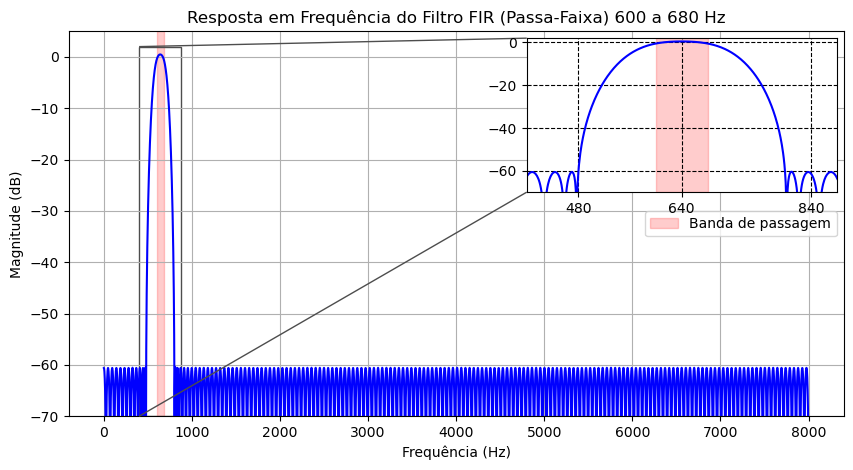

In [168]:
# Frequências normalizadas (0 a 1, onde 1 corresponde a fs/2)
nyq = sample_rate / 2

band = [600, 680]
trans_width = 120 # Quanto maior a faixa de transição melhor o resultado de atenuação na banda de rejeição 
edges = [0, band[0] - trans_width, band[0], band[1], band[1] + trans_width, 0.5*sample_rate]

desired_gain = [0, 1, 0]
weights = [60, 1, 60]
num_taps = 340 # Ampliando a faixa de transição, pode-se obter um filtro adequado e com menor pontos

taps  = remez(num_taps, edges, desired_gain, weight=weights, fs=sample_rate)
w, h = freqz(taps, worN=8000, fs=sample_rate)

fig, axs = plt.subplots(figsize=(10, 5))

axs.plot(w, 20 * np.log10(np.abs(h)), 'b')
axs.set_title(f'Resposta em Frequência do Filtro FIR (Passa-Faixa) {edges[2]} a {edges[3]} Hz')
axs.set_xlabel('Frequência (Hz)')
axs.set_ylabel('Magnitude (dB)')
axs.set_ylim(-70, 5)
axs.grid(True)
axs.axvspan(edges[2], edges[3], color='red', alpha=0.2, label='Banda de passagem')
axs.legend(loc='center right')

axins = inset_axes(axs, width="40%", height="40%", loc="upper right", bbox_transform=axs.transAxes)

axins.plot(w, 20 * np.log10(np.abs(h)), 'b')
axins.set_xlim(edges[1] - 80, edges[4] + 80)  
axins.set_ylim(-70, 2)  
axins.grid(True, color='black', linestyle='--')  
# axins.set_yticks()
axins.set_xticks([edges[1], frequencias[0], frequencias[1]]) 
axins.axvspan(band[0], band[1], color='red', alpha=0.2, label='Banda de passagem')

mark_inset(axs, axins, loc1=2, loc2=3, fc="none", ec="0.3")

plt.savefig(f'FIR_{frequencias[0]}Hz', bbox_inches='tight')

In [ ]:
# Convolução no tempo entre os dados de áudio e filtro
cos_filtrado = np.convolve(data, taps)

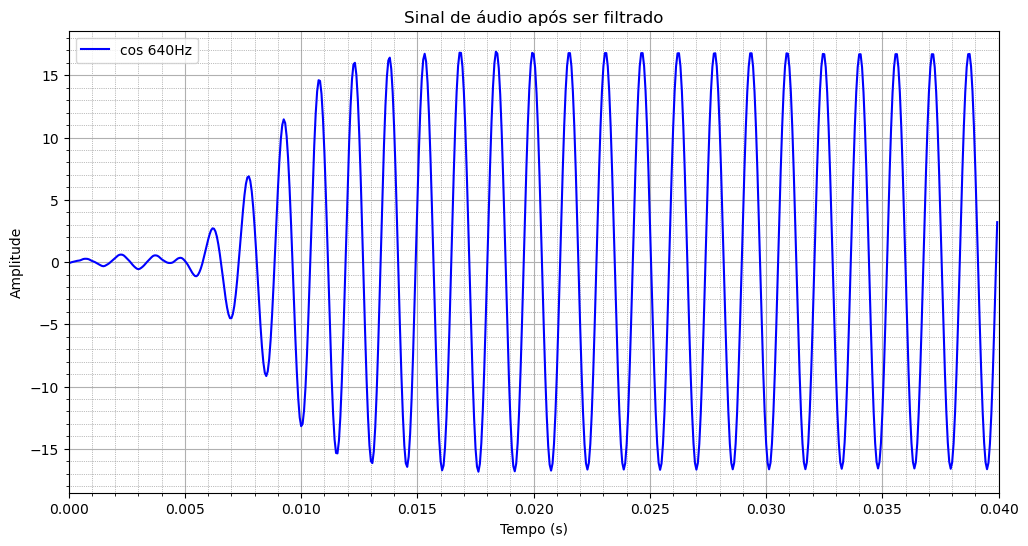

In [160]:
visual_time = 0.04 # Tempo de visualização, pois há muitas amostras para plotar
n_samples = int(sample_rate * visual_time) # Quantidade de amostras a serem plotadas
T = 1/sample_rate
time = np.linspace(0, T*len(data), len(data)) 

plt.figure(figsize=(12, 6))
plt.plot(time[:n_samples], cos_filtrado[:n_samples], label="cos 640Hz", color='b')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal de áudio após ser filtrado')
plt.legend(loc='best')
plt.xlim(0, visual_time)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.8)
plt.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')

plt.savefig(f'SinalFiltrador_{frequencias[0]}Hz', bbox_inches='tight')

In [163]:
# Tempo de atraso por conta da quantidade de taps do filtro
print(f'Tempo de atraso provocado pelo filtro: {num_taps*T}s')

Tempo de atraso provocado pelo filtro: 0.02125s
